In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/vgg16-models-mnist-fashion-mnist/vgg16_fashion-mnist_model.pth
/kaggle/input/vgg16-models-mnist-fashion-mnist/vgg16_mnist_model.pth


In [2]:
# Import libraries and packages
from PIL import Image
import matplotlib.pyplot as plt  # plot graphs and images

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms
from torchvision import models

### Using GPU-T4

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## FGSM (Fast Gradient Sign Method) Adversarial Attack
Deep Learning models are notoriously known for being overconfident in their predictions. Szegedy et al. [1] discovered that Deep Neural Network models can be manipulated into making wrong predictions by adding small perturbations to the input image.

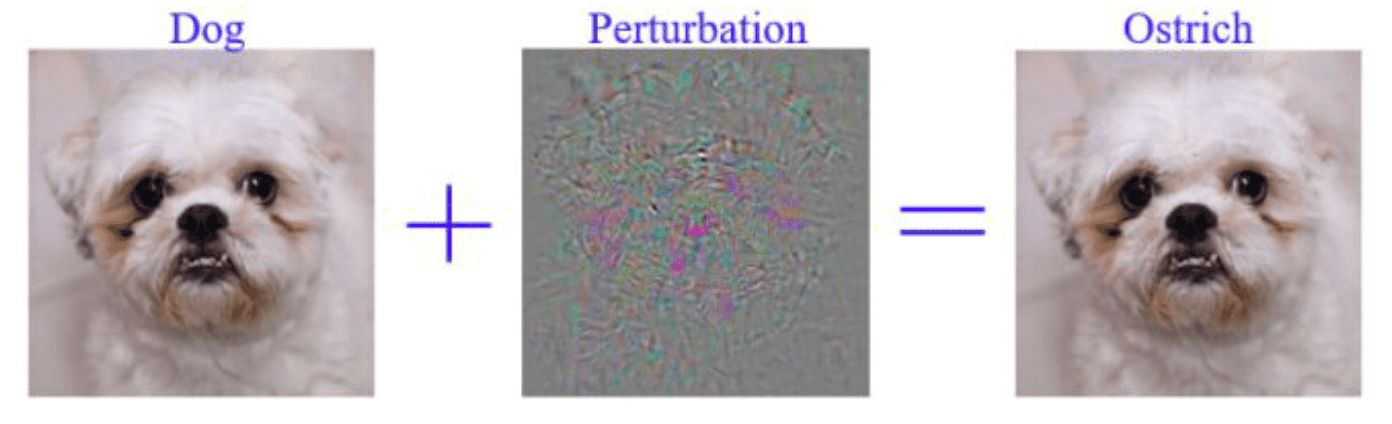
Fig 1: Szegedy et al. were able to fool AlexNet by classifying a perturbed image of a dog into an ostrich

Goodfellow et.al. [2] exploited the linearity of neural networks in higher dimensions to enable effective adversarial training to efficiently compute an adversarial perturbation for a given image. Fast Gradient Sign Method solves computes ρ as : 
<br/>
$\rho = \epsilon \;sign(\nabla J(\theta, I_c, l))$
<br/>where gradient of cost function around the current value of model parameters 𝛉 w.r.t. I<sub>C</sub> and ϵ bounds the l-∞ norm.

References -
<br/>
[1] Intriguing properties of neural networks - Christian Szegedy, Wojciech Zaremba, Ilya Sutskever, Joan Bruna, Dumitru Erhan, Ian Goodfellow, Rob Fergus (https://arxiv.org/abs/1312.6199)
<br/>
[2] Explaining and Harnessing Adversarial Examples - Ian J. Goodfellow, Jonathon Shlens, Christian Szegedy (https://arxiv.org/abs/1412.6572)


In [4]:
def perturb(imgs, eps, data_grads):
    # Collect the element-wise sign of the data gradient
    sign_data_grads = data_grads.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    adv_imgs = imgs + eps * sign_data_grads
    # Adding clipping to maintain [0,1] range
    adv_imgs = torch.clamp(adv_imgs, 0, 1)
    # Return the perturbed image
    return adv_imgs

In [5]:
def fgsm_attack(model, imgs, labels, eps):
    imgs.required_grad = True
    
    outputs = model(imgs)
    loss = F.nll_loss(outputs, labels)
    
    model.zero_grad()
    loss.backward()
    data_grads = imgs.grad.data
    
    adv_imgs = perturb(imgs, eps, data_grads)
    outputs = model(adv_imgs)
    new_preds = outputs.argmax(axis=1)
    
    return adv_imgs, new_preds

In [6]:
# Storing different values of epsilon - determining the degree of attack
epsilons = [0.00, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 1.0, 1.5]

## VGG-16 (Loading pre-trained model)

In [7]:
class VGGBlock(nn.Module):
    def __init__(self, in_channels, out_channels, batch_norm=False):
        super().__init__()
        conv2_params = {'kernel_size': (3, 3),
                        'stride'     : (1, 1),
                        'padding'   : 1}

        noop = lambda x : x
        self._batch_norm = batch_norm

        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels , **conv2_params)
        self.bn1 = nn.BatchNorm2d(out_channels) if batch_norm else noop

        self.conv2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, **conv2_params)
        self.bn2 = nn.BatchNorm2d(out_channels) if batch_norm else noop

        self.max_pooling = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

    @property
    def batch_norm(self):
        return self._batch_norm

    def forward(self,x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)

        x = self.max_pooling(x)

        return x
    

class VGG16(nn.Module):
    def __init__(self, input_size, num_classes=10, batch_norm=False):
        super(VGG16, self).__init__()

        self.in_channels, self.in_width, self.in_height = input_size

        self.block_1 = VGGBlock(self.in_channels, 64, batch_norm=batch_norm)
        self.block_2 = VGGBlock(64, 128, batch_norm=batch_norm)
        self.block_3 = VGGBlock(128, 256, batch_norm=batch_norm)
        self.block_4 = VGGBlock(256,512, batch_norm=batch_norm)

        self.classifier = nn.Sequential(
                nn.Linear(2048, 4096),
                nn.ReLU(True),
                nn.Dropout(p=0.65),
                nn.Linear(4096, 4096),
                nn.ReLU(True),
                nn.Dropout(p=0.65),
                nn.Linear(4096, num_classes) 
            )

    @property
    def input_size(self):
          return self.in_channels, self.in_width, self.in_height

    def forward(self, x):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.block_3(x)
        x = self.block_4(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)

        return x

In [8]:
model = VGG16((1,32,32), batch_norm=True)
model.to(device)

VGG16(
  (block_1): VGGBlock(
    (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (max_pooling): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): VGGBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (max_pooling): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (block_3): VGGBlock(
    (conv1): Conv2d(128,

## Load the MNIST dataset

In [9]:
transform=transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
])

test_dataset = torchvision.datasets.MNIST(root='/kaggle/temp/', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 100702693.54it/s]


Extracting /kaggle/temp/MNIST/raw/train-images-idx3-ubyte.gz to /kaggle/temp/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 49523995.84it/s]

Extracting /kaggle/temp/MNIST/raw/train-labels-idx1-ubyte.gz to /kaggle/temp/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 26111202.38it/s]


Extracting /kaggle/temp/MNIST/raw/t10k-images-idx3-ubyte.gz to /kaggle/temp/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 22023732.68it/s]


Extracting /kaggle/temp/MNIST/raw/t10k-labels-idx1-ubyte.gz to /kaggle/temp/MNIST/raw



In [10]:
# Load the saved checkpoint 
model.load_state_dict(torch.load('/kaggle/input/vgg16-models-mnist-fashion-mnist/vgg16_mnist_model.pth'))

<All keys matched successfully>

In [11]:
accs = []
for eps in epsilons:
    total = 0
    correct = 0

    for i, (imgs, labels) in enumerate(test_loader):
        imgs = imgs.to(device)
        labels = labels.to(device)
        # print(labels.shape)
        imgs = Variable(imgs, requires_grad=True)
        labels = Variable(labels)

        new_imgs, new_preds = fgsm_attack(model, imgs, labels, eps)
        correct += (new_preds==labels).sum().item()
        total += labels.size(0)

    accs.append((correct / total))
    print("Epsilon: {}, Test Accuracy: {}".format(eps, correct / total))

Epsilon: 0.0, Test Accuracy: 0.9901
Epsilon: 0.1, Test Accuracy: 0.9099
Epsilon: 0.2, Test Accuracy: 0.8237
Epsilon: 0.3, Test Accuracy: 0.7274
Epsilon: 0.4, Test Accuracy: 0.584
Epsilon: 0.5, Test Accuracy: 0.4054
Epsilon: 0.6, Test Accuracy: 0.2648
Epsilon: 0.7, Test Accuracy: 0.161
Epsilon: 1.0, Test Accuracy: 0.0531
Epsilon: 1.5, Test Accuracy: 0.0523


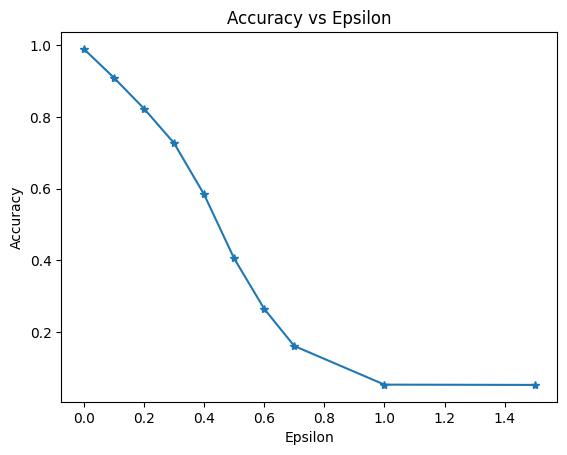

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=1)  # create figure & 1 axis
ax.plot(epsilons, accs, "*-")
ax.set_title("Accuracy vs Epsilon")
ax.set_xlabel("Epsilon")
ax.set_ylabel("Accuracy")
fig.show()

As evident from the figure, as the epsilon value (ϵ) increases, the accuracy of the VGG-16 model falls drastically, finally becoming ≈5% (from 99%) when ϵ >= 1.00

In [13]:
def to_numpy_array(tensor):
    '''Convert torch.Tensor to np.ndarray'''
    tensor_ = tensor.cpu()
    tensor_ = tensor_.squeeze(0)
    tensor_ = tensor_.detach().numpy()
    return tensor_

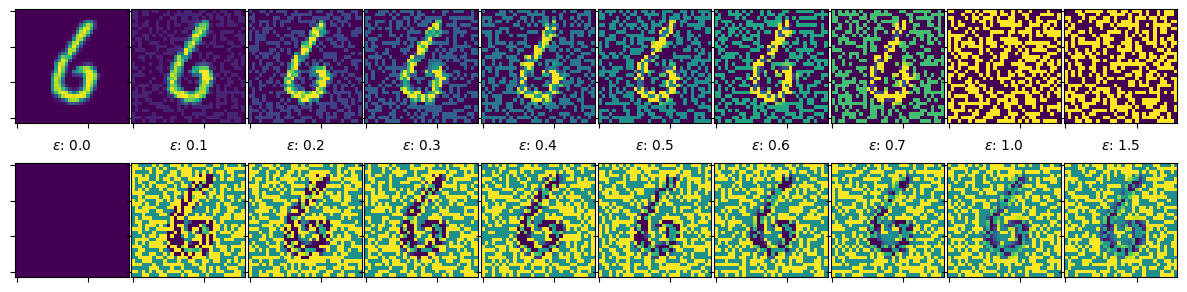

In [14]:
for i, (imgs, labels) in enumerate(test_loader):
    imgs, labels = imgs.to(device), labels.to(device)
    imgs, labels = Variable(imgs, requires_grad=True), Variable(labels)

    f = plt.figure(figsize=(15, 7))
    gs = f.add_gridspec(2, len(epsilons))
    gs.update(wspace=0.025, hspace=-0.6) 

    # plot the perturbed image
    for e in range(len(epsilons)):
        eps = epsilons[e]
        ax1 = f.add_subplot(gs[0, e])
        imgs, labels = imgs.to(device), labels.to(device)
        imgs, labels = Variable(imgs, requires_grad=True), Variable(labels)

        adv_imgs, _ = fgsm_attack(model, imgs, labels, eps)

        img, adv_img = imgs[50], adv_imgs[50]
        img, adv_img = to_numpy_array(img), to_numpy_array(adv_img)

        ax1.imshow(adv_img)
        ax1.set_xlabel(f"$\epsilon$: {eps}")
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])

    # plot the perturbation or noise added to the image
    for i in range(len(epsilons)):
        eps = epsilons[i]
        ax2 = f.add_subplot(gs[1, i])
        imgs, labels = imgs.to(device), labels.to(device)
        imgs, labels = Variable(imgs, requires_grad=True), Variable(labels)

        adv_imgs, _ = fgsm_attack(model, imgs, labels, eps)

        img, adv_img = imgs[50], adv_imgs[50]
        img, adv_img = to_numpy_array(img), to_numpy_array(adv_img)
        noise = adv_img - img

        ax2.imshow(noise)
        ax2.set_xticklabels([])
        ax2.set_yticklabels([])

    f.show()
    break 

## Load Fashion-MNIST dataset

In [15]:
transform=transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
])

test_dataset = torchvision.datasets.FashionMNIST(root='/kaggle/temp/', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

100%|██████████| 26421880/26421880 [00:01<00:00, 18053442.04it/s]


Extracting /kaggle/temp/FashionMNIST/raw/train-images-idx3-ubyte.gz to /kaggle/temp/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 272125.71it/s]


Extracting /kaggle/temp/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /kaggle/temp/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 4943360.04it/s]


Extracting /kaggle/temp/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /kaggle/temp/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 9424826.27it/s]

Extracting /kaggle/temp/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /kaggle/temp/FashionMNIST/raw



In [16]:
# Load the saved checkpoint 
model = VGG16((1,32,32), batch_norm=True)
model.to(device)
model.load_state_dict(torch.load('/kaggle/input/vgg16-models-mnist-fashion-mnist/vgg16_fashion-mnist_model.pth'))

<All keys matched successfully>

In [17]:
accs = []
for eps in epsilons:
    total = 0
    correct = 0

    for i, (imgs, labels) in enumerate(test_loader):
        imgs = imgs.to(device)
        labels = labels.to(device)
        # print(labels.shape)
        imgs = Variable(imgs, requires_grad=True)
        labels = Variable(labels)

        new_imgs, new_preds = fgsm_attack(model, imgs, labels, eps)
        correct += (new_preds==labels).sum().item()
        total += labels.size(0)

    accs.append((correct / total))
    print("Epsilon: {}, Test Accuracy: {}".format(eps, correct / total))

Epsilon: 0.0, Test Accuracy: 0.9122
Epsilon: 0.1, Test Accuracy: 0.4751
Epsilon: 0.2, Test Accuracy: 0.3798
Epsilon: 0.3, Test Accuracy: 0.2973
Epsilon: 0.4, Test Accuracy: 0.2376
Epsilon: 0.5, Test Accuracy: 0.1889
Epsilon: 0.6, Test Accuracy: 0.1417
Epsilon: 0.7, Test Accuracy: 0.0955
Epsilon: 1.0, Test Accuracy: 0.0444
Epsilon: 1.5, Test Accuracy: 0.0412


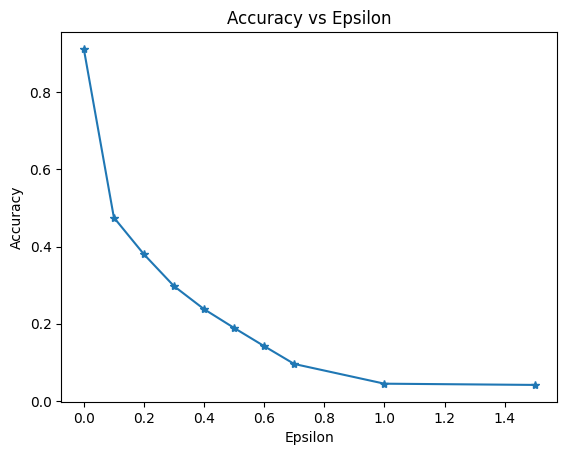

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=1)  # create figure & 1 axis
ax.plot(epsilons, accs, "*-")
ax.set_title("Accuracy vs Epsilon")
ax.set_xlabel("Epsilon")
ax.set_ylabel("Accuracy")
fig.show()

For the Fashion MNIST dataset, we can see that the accuracy drops directly to 47% from 91% when we apply an epsilon (ϵ) of 0.1 and goes down drastically to ≈4% as ϵ increases to >= 1.0

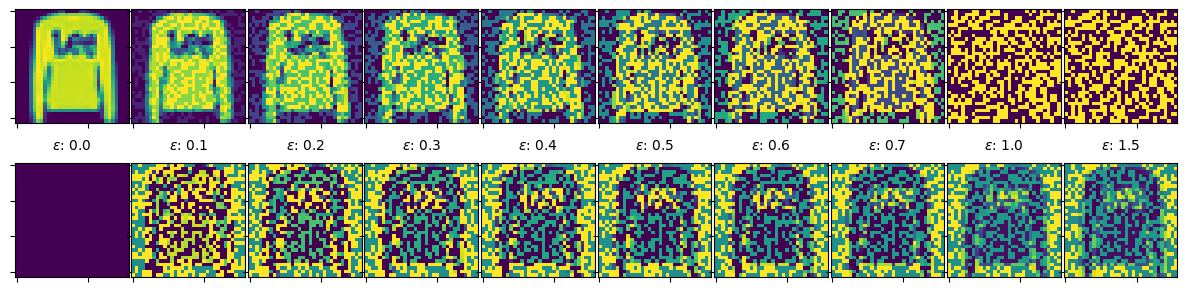

In [19]:
for i, (imgs, labels) in enumerate(test_loader):
    imgs, labels = imgs.to(device), labels.to(device)
    imgs, labels = Variable(imgs, requires_grad=True), Variable(labels)

    f = plt.figure(figsize=(15, 7))
    gs = f.add_gridspec(2, len(epsilons))
    gs.update(wspace=0.025, hspace=-0.6) 

    # plot the perturbed image
    for e in range(len(epsilons)):
        eps = epsilons[e]
        ax1 = f.add_subplot(gs[0, e])
        imgs, labels = imgs.to(device), labels.to(device)
        imgs, labels = Variable(imgs, requires_grad=True), Variable(labels)

        adv_imgs, _ = fgsm_attack(model, imgs, labels, eps)

        img, adv_img = imgs[1], adv_imgs[1]
        img, adv_img = to_numpy_array(img), to_numpy_array(adv_img)

        ax1.imshow(adv_img)
        ax1.set_xlabel(f"$\epsilon$: {eps}")
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])

    # plot the perturbation or noise added to the image
    for i in range(len(epsilons)):
        eps = epsilons[i]
        ax2 = f.add_subplot(gs[1, i])
        imgs, labels = imgs.to(device), labels.to(device)
        imgs, labels = Variable(imgs, requires_grad=True), Variable(labels)

        adv_imgs, _ = fgsm_attack(model, imgs, labels, eps)

        img, adv_img = imgs[1], adv_imgs[1]
        img, adv_img = to_numpy_array(img), to_numpy_array(adv_img)
        noise = adv_img - img

        ax2.imshow(noise)
        ax2.set_xticklabels([])
        ax2.set_yticklabels([])

    f.show()
    break 